# Switching Recurrent Neural Networks (SRNNs) Tutorial on Lorenz Attractor

### Step 1: Package load
In this step, we load the packages of SRNNs. **Please note** the initializatins are very important to SRNNs as well as other SSM models to shorten training time and avoid stuck of training as we discussed in our paper. If you use HMM as a initialization, you have two options:
<br>
(1) We provide HMM package from Linderman SSM, you may **import ssm** to test whether the SSM package is installed. If so, you can specify the initialization method to be 'hmm' in step 5.
<br>
(2) If the ssm doesn't work for you or you would like to use your own initialization (e.g., your own HMM, your own labels, etc.), please change the initialization method to be 'defined'.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os
from SRNN import model_srnn
from SRNN import inference_network
from SRNN import initialization
from SRNN import train
from SRNN import generative_check
from sklearn.metrics import mean_squared_error

np.random.seed(131)
torch.manual_seed(131)

### Step 2: Data load
In this step, we load and visualize the data of lorenz attractor.

In [2]:
y_c=np.load('./data/lorenz_new.npy')

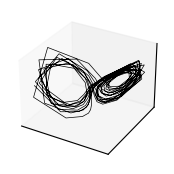

In [3]:
# Let's visualize one trial of lorenz attractors.
ax = plt.figure(figsize=(2,2)).add_subplot(projection='3d')
ax.plot(y_c[0,:,0],y_c[0,:,1],y_c[0,:,2], lw=0.5,color='black')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()

We then split the data into training and testing, i.e., 17 trials in training and 1 trials in testing. 'jobid' is to set which trial in testing.

In [4]:
jobid=0
train_data=np.delete(y_c,(int(jobid)),axis=0)
test_data=y_c[int(jobid):int(jobid)+1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
X_train=torch.tensor(0*train_data,dtype=dtype,device=device)
y_train=torch.tensor(train_data,dtype=dtype,device=device)
y_test=torch.tensor(test_data,dtype=dtype,device=device)
X_test=torch.tensor(0*test_data,dtype=dtype,device=device)
### beh_all_train and beh_all_test are behavioral labels, we don't have to use them in lorenz attractor.
beh_all_train=None
beh_all_test=None

### Step 3: Hyperparameters

In [5]:
input_shape=X_train.shape[2] # Input shape of SRNNs, but the models are input free.
num_tv=2 # Number of RNNs in SRNNs.
hidden_shape=3 # Number of hidden states of SRNNs.
ini_epochs=200 # Epochs in initialization stage, can be longer than training stage.
coef_cross=5e-1 # Coefficient of initialization, larger coef_cross means larger constraint on posterior states in initialization. 
epochs=4000 # Epochs in training stage.
lr=0.001 # Learning rate

### Step 4: Define SRNN and Inference Networks

In [6]:
model = model_srnn.Model(input_shape,num_tv,hidden_shape).to(device)
rnninfer=inference_network.RNNInfer(input_shape,hidden_shape).to(device)

In [7]:
print(model);print(rnninfer)

Model(
  (rnns): ModuleList(
    (0-1): 2 x RNN(3, 3, batch_first=True)
  )
  (emission): Emission(
    (fc1): Linear(in_features=3, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=3, bias=True)
    (relu): ReLU()
  )
  (transitions): RNNCell(3, 4)
)
RNNInfer(
  (forward_rnn): RNN(3, 3, batch_first=True)
  (backward_rnn): RNN(3, 3, batch_first=True)
  (rnn_mean): RNN(3, 3, batch_first=True)
  (lc1): Linear(in_features=6, out_features=64, bias=True)
  (lc2): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
)


### Step 5: Initialization

#### Here, we use 'random' initialization which is to initialize the SRNNs using random states. SRNNs are also able to identify correct discrete states, which means that the identification of SRNNs is not due to the initialization.

In [8]:
optimizer = torch.optim.Adam(list(model.parameters())+list(rnninfer.parameters()) ,lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.8)


In [9]:
model_ini,rnninfer_ini,mse_all_ini,error_all_ini,mse_all_test_ini,error_all_test_ini,loss_all_ini,pos_test_all_ini=initialization.run(model,
                                                                                                                     rnninfer,
                                                                                                                     optimizer,
                                                                                                                     scheduler,
                                                                                                                     X_train,
                                                                                                                     y_train,
                                                                                                                     X_test,
                                                                                                                     y_test,
                                                                                                                     beh_all_train,
                                                                                                                     beh_all_test,
                                                                                                                     num_tv,
                                                                                                                     coef_cross,
                                                                                                                     ini_epochs,
                                                                                                                     device,
                                                                                                                     method='random',
                                                                                                                     t_load=None)

Epoch 1/200, loss = 57692976.44442052
Epoch 101/200, loss = 14769867.18716073
Training Still Needs :- 00d00h03m37s  (Estimated).


Now, we can test the SRNN after initialization. We see that SRNNs after random initialization do not work well. However, the initialization is necessary in order to avoid SRNNs being stuck in one state.

In [10]:
y_pred_test_ini,pos_test_ini,sampled_h_test_ini=train.eval_(model_ini,rnninfer_ini,X_test,y_test,device)

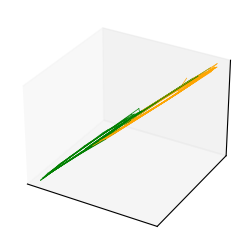

In [11]:
color_list=['green','orange']
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
for i in range(len(y_pred_test_ini[0])-2):
    ax.plot(y_pred_test_ini[0,i:i+2,0],y_pred_test_ini[0,i:i+2,1],y_pred_test_ini[0,i:i+2,2], lw=0.5,color=color_list[int(np.argmax(pos_test_ini[0],axis=1)[i])])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()

### Step 6: Training

In [12]:
model_trained,rnninfer_trained,mse_all_train,error_all_train,mse_all_test,error_all_test,loss_all_test,pos_test_all=train.train_(model_ini,
                                                                                                                    rnninfer_ini,
                                                                                                                    optimizer,
                                                                                                                    scheduler,
                                                                                                                    X_train,
                                                                                                                    y_train,
                                                                                                                    X_test,
                                                                                                                    y_test,
                                                                                                                    beh_all_train,
                                                                                                                    beh_all_test,
                                                                                                                    num_tv,
                                                                                                                    epochs,
                                                                                                                    device)

Epoch 1/4000, loss = 8046533.0
Epoch 101/4000, loss = 3115457.5
Training Still Needs :- 00d02h17m40s  (Estimated).
Epoch 201/4000, loss = 634289.5625
Training Still Needs :- 00d02h14m29s  (Estimated).
Epoch 301/4000, loss = 258384.40625
Training Still Needs :- 00d02h11m14s  (Estimated).
Epoch 401/4000, loss = 158923.84375
Training Still Needs :- 00d02h07m49s  (Estimated).
Epoch 501/4000, loss = 109348.921875
Training Still Needs :- 00d02h04m17s  (Estimated).
Epoch 601/4000, loss = 80116.671875
Training Still Needs :- 00d02h00m45s  (Estimated).
Epoch 701/4000, loss = 59980.14453125
Training Still Needs :- 00d01h57m08s  (Estimated).
Epoch 801/4000, loss = 43192.8671875
Training Still Needs :- 00d01h53m16s  (Estimated).
Epoch 901/4000, loss = 30768.248046875
Training Still Needs :- 00d01h49m30s  (Estimated).
Epoch 1001/4000, loss = 21154.171875
Training Still Needs :- 00d01h45m47s  (Estimated).
Epoch 1101/4000, loss = 28138.328125
Training Still Needs :- 00d01h42m07s  (Estimated).
Epoch 1

Now, we can test the SRNN after training.

### Step 7: Analysis

In [13]:
y_pred_test,pos_test,sampled_h_test=train.eval_(model_trained,rnninfer_trained,X_test,y_test,device)

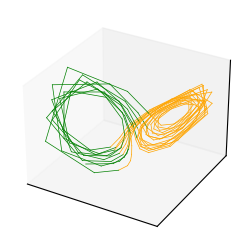

In [14]:
# Let's visualize.
color_list=['green','orange']
ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
for i in range(len(y_pred_test[0])-2):
    ax.plot(y_pred_test[0,i:i+2,0],y_pred_test[0,i:i+2,1],y_pred_test[0,i:i+2,2], lw=0.5,color=color_list[int(np.argmax(pos_test[0],axis=1)[i])])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()

Now, check validation loss and MSE of training.

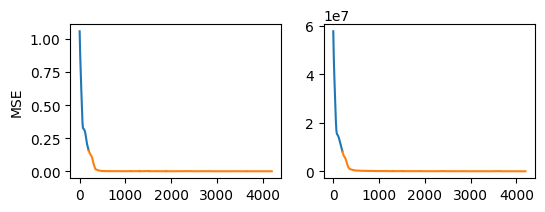

In [15]:
plt.figure(figsize=(6,2))
plt.subplot(1,2,1)
plot_epoch=range(ini_epochs+epochs)
plt.plot(plot_epoch[:ini_epochs],mse_all_test_ini)
plt.plot(plot_epoch[ini_epochs:],mse_all_test)
plt.ylabel('MSE')
plt.subplot(1,2,2)
plot_epoch=range(ini_epochs+epochs)
plt.plot(plot_epoch[:ini_epochs],loss_all_ini)
plt.plot(plot_epoch[ini_epochs:],loss_all_test)
plt.show()

Now, let's test whether the generative model works and can generate right trajectory using inferred discrete states.

In [16]:
generative_y_test,generative_h=generative_check.run(model,rnninfer,X_test,y_test,pos_test,device)

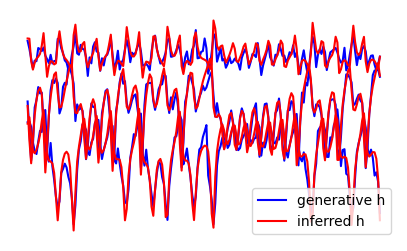

In [17]:
plt.figure(figsize=(5,3))
lines=plt.plot(generative_h,color='blue',label='generative h')
plt.setp(lines[1:],label='_')
lines=plt.plot(sampled_h_test[0],color='red',label='inferred h')
plt.setp(lines[1:],label='_')
plt.legend()
plt.axis('off')
plt.show()

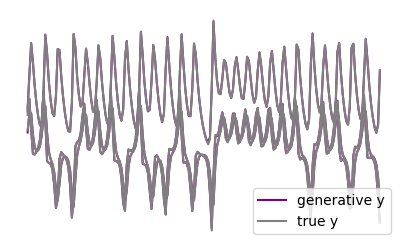

In [18]:
plt.figure(figsize=(5,3))
lines=plt.plot(y_pred_test[0],color='purple',label='generative y')
plt.setp(lines[1:],label='_')
lines=plt.plot(y_test.cpu().detach().numpy()[0],color='gray',label='true y')
plt.setp(lines[1:],label='_')
plt.legend()
plt.axis('off')
plt.show()

Now, let's look at how states identified by SRNNs change across epochs.

In [19]:
state_all_ini=[]
for i in range(ini_epochs):
    state_all_ini.append(np.argmax(pos_test_all_ini[i,0,:,:],axis=1))
state_all_ini=np.array(state_all_ini)

state_all=[]
for i in range(epochs):
    state_all.append(np.argmax(pos_test_all[i,0,:,:],axis=1))
state_all=np.array(state_all)

state_entire=np.vstack((state_all_ini,state_all))

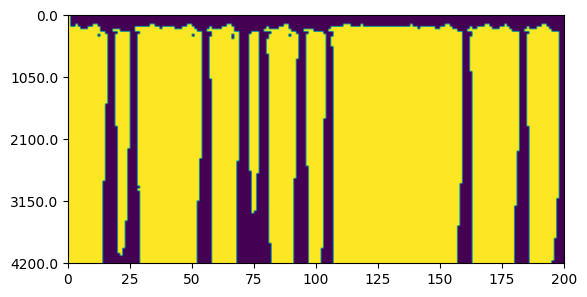

In [20]:
fig, ax = plt.subplots(1,1)
l=int(state_entire.shape[0]/100)
state_show=state_entire[0:1]
for i in range(100):
    state_show=np.vstack((state_show,state_entire[i*l+l:i*l+l+1]))
ax.imshow(state_show,extent=[0,state_show.shape[1],state_entire.shape[0]/l,0])
y_label_list = list(np.linspace(0,state_entire.shape[0],5))
ax.set_yticks(list(np.linspace(0,state_show.shape[0],5)))
ax.set_yticklabels(y_label_list)
plt.show()